# Fault Detection with VAR Models

### Plot the dataset
##### I want to fix the model problem to predict the other attributes

In [543]:
# Importing packages and libraries
from pandas import read_csv
import pandas as pd
import numpy as np
import pickle
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [544]:
def plot_multiple_series(actual, pred, attr):
    
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(actual.iloc[:,i], label="actual")
        plt.plot(pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()
#     return

def write_result(numbers, filename):
    with open(filename, 'a') as f:
        f.write(','.join(map(str, numbers)) + '\n')

result_file = 'result_file.txt'

In [545]:
def root_mse(x, y):
    if len(x) != len(y):
        return "Error: The two arguments must have the same length"
    mse = np.square(np.subtract(x, y)).mean()
    return np.sqrt(mse)



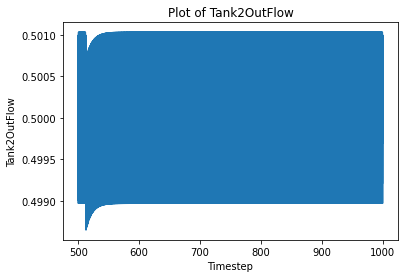

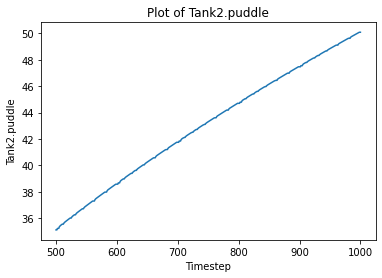

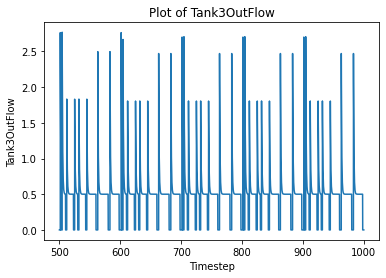

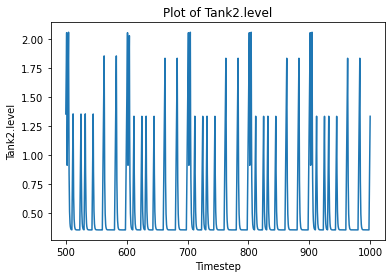

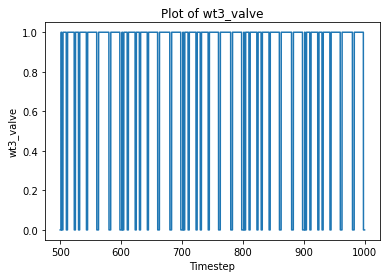

In [546]:
def plot_series(series, attr):
    for i in range(len(attr)):
        title = "Plot of "+str(attr[i])
        actual = series.iloc[:,i]
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel(attr[i])
        plt.plot(actual)
        plt.show()
        
# file = 'test_series_reduced.csv'
# file = 'stuckat0_training_reduced_new.csv'
file = 'stuckat1_training_reduced_new.csv'
# file = 'valueFlip_training_reduced_new.csv'
# file = 'waterTank_Golden_reduced.csv'

df_raw = read_csv(file, header=0, index_col=0)
attr = list(pd.read_csv(file).columns.values)[1:]        
# series = df_raw.iloc[:40000,:]
series = df_raw.iloc[10000:35000,:]
# series = df_raw.iloc[15000:30000,:]
# series = df_raw.iloc[20000:35000,:]
plot_series(series, attr)

### Normalisation of the golden dataset
##### This is to obtain the mean and standard deviation that would be used for normalising all the datasets

In [547]:
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)



def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)



normalised_data = normalise_timeseries(df_raw)

In [548]:
testData = normalised_data
testData

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,-11.718138,-2.682776,-1.325938,-1.493747,-2.020925
0.05,-11.718138,-2.682776,-1.325938,-1.493747,-2.020925
0.10,-11.718138,-2.682776,-1.325938,-1.493747,-2.020925
0.15,-11.718138,-2.682776,-1.325938,-1.493747,-2.020925
0.20,-11.718138,-2.682776,-1.325938,-1.493747,-2.020925
...,...,...,...,...,...
999.80,0.126510,1.391705,-1.325938,1.845914,-2.020925
999.85,0.133595,1.391705,-1.325938,1.899891,-2.020925
999.90,0.169767,1.391705,-1.325938,1.980885,-2.020925


In [549]:
# Train Test Split
nobs = 3000
# train = df[:-nobs]
train = testData.iloc[:-nobs]
test = testData.iloc[-nobs:]
len(train), len(test)

(17001, 3000)

### Load the saved models

In [550]:
# The saved models are loaded to reconstruct the VAR
# attr = list(pd.read_csv('waterTank_Golden_reduced.csv').columns.values)[1:]
attr = list(pd.read_csv(file).columns.values)[1:]
with open('var_golden_model_reduced.pkl', 'rb') as f:
    golden_model = pickle.load(f)

with open('var_ctrl_valueFlip_perm_reduced.pkl', 'rb') as vf:
    valueFlip_model = pickle.load(vf)    

with open('var_ctrl_stuckat0_perm_reduced.pkl', 'rb') as stuck0:
    stuckat0_model = pickle.load(stuck0)    

with open('var_ctrl_stuckat1_perm_reduced.pkl', 'rb') as stuck1:
    stuckat1_model = pickle.load(stuck1)



In [551]:

# golden_model = VAR.load('var_golden_model.pkl')

# Retrieve the lag order
lag_order = golden_model.k_ar
# lag_order = 19

# Prepare new data
# newData = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
# newData = newData[attr]
# newData = newData[-lag_order:]
# newData = newData[:200,:]

# Initialise the VAR model
model_input = train.values
# model_input = newData.values
# golden_model.initialize_known(model_input)

# Make predictions
predictions = golden_model.forecast(model_input, steps=5)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=train.columns)

print(predictions_df)


   Tank2OutFlow  Tank2.puddle  Tank3OutFlow  Tank2.level  wt3_valve
0      0.123015      1.071273      0.775390    -0.558899   0.624167
1      0.136930      1.069102      1.116615    -0.693024   0.924337
2      0.160087      1.066122      1.456376    -0.816802   1.194490
3      0.156070      1.062975      1.716280    -1.018255   1.365661
4      0.126661      1.059218      1.843352    -1.199159   1.525871


In [552]:
test

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
850.05,0.126510,1.072864,0.030851,-0.526706,0.494823
850.10,0.144185,1.072999,0.030367,-0.527050,0.494823
850.15,0.169767,1.073089,0.030161,-0.527197,0.494823
850.20,0.168293,1.073224,0.030110,-0.527234,0.494823
850.25,0.143823,1.073314,0.030078,-0.527257,0.494823
...,...,...,...,...,...
999.80,0.126510,1.391705,-1.325938,1.845914,-2.020925
999.85,0.133595,1.391705,-1.325938,1.899891,-2.020925
999.90,0.169767,1.391705,-1.325938,1.980885,-2.020925


### Plot the input signals

In [553]:
def plot_multiple_series(actual, pred, attr):
    if len(actual) != len(pred):
        return "Error: The lengths of the two data must be the same!"
    x = range(len(pred))
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(x, actual.iloc[:,i].values, label="actual")
        plt.plot(x, pred.iloc[:,i].values, label="forecast")
        plt.legend()
        plt.show()
#     return


In [554]:
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)

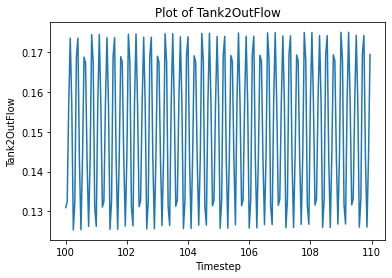

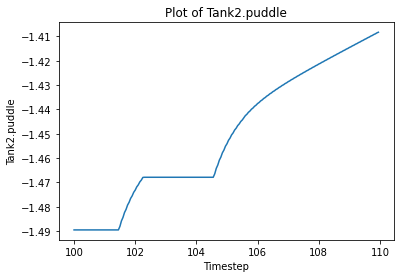

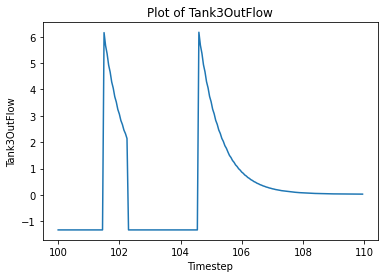

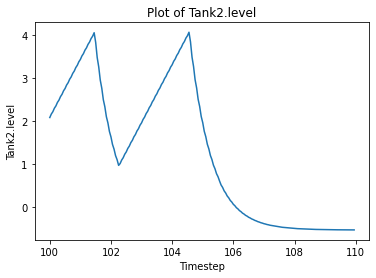

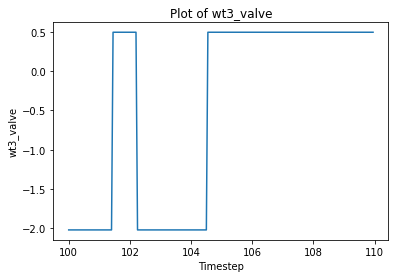

In [555]:
## SPecify the signal range of the golden data
begin = 2000
finish = 2200
input1 = testData.iloc[begin:finish,:]

## Visualise the input signals
plot_series(input1,attr)

# attr = list(pd.read_csv('test_series.csv').columns.values)[1:]
# for i in range(len(attr)):
#     title = "Input of {}".format(attr[i])
#     plt.title(title)
#     plt.xlabel("Timesteps")
#     plt.ylabel("Normalised values")
#     plt.plot(input1.iloc[:,i])
#     plt.show()

### Predict with the pretrained models (Golden data)
#### Golden model

In [556]:
steps = 15
predictions = golden_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=input1.columns)

print(predictions_df)

    Tank2OutFlow  Tank2.puddle  Tank3OutFlow  Tank2.level  wt3_valve
0       0.164075     -1.409584      0.768546    -0.560094   0.606104
1       0.135645     -1.411504      1.084980    -0.690588   0.866505
2       0.117201     -1.414160      1.370942    -0.806260   1.130947
3       0.132587     -1.417004      1.626045    -0.997540   1.266874
4       0.158358     -1.420409      1.706596    -1.164192   1.421456
5       0.146296     -1.424006      1.800737    -1.373284   1.473309
6       0.106605     -1.428020      1.756460    -1.553096   1.554402
7       0.099223     -1.432076      1.753551    -1.753938   1.529163
8       0.124899     -1.436450      1.612961    -1.923251   1.537141
9       0.138158     -1.440947      1.514721    -2.093392   1.478896
10      0.116600     -1.445563      1.330642    -2.232446   1.461369
11      0.088166     -1.450194      1.217238    -2.364833   1.402576
12      0.086635     -1.454867      1.054308    -2.474075   1.390591
13      0.109000     -1.459562    

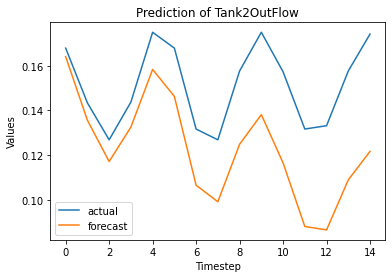

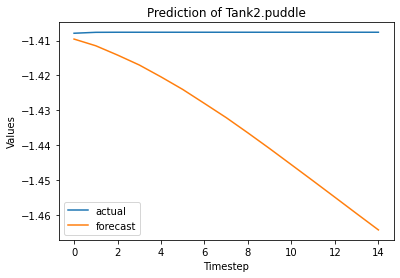

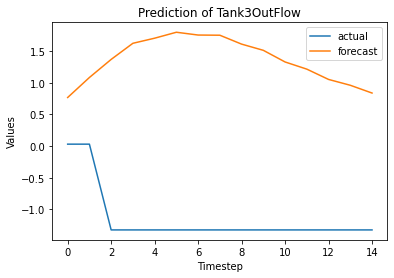

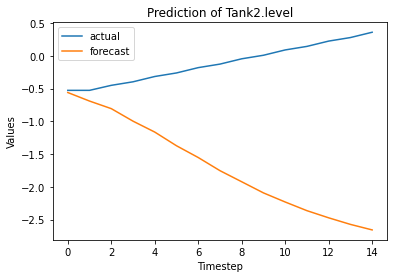

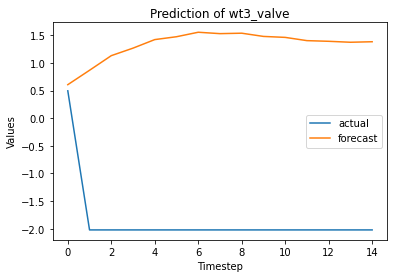

In [557]:
# plot_series(predictions_df, attr)
expected = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected, predictions_df, attr)
# plot_multiple_series(actual, pred, attr)

In [558]:
expected = expected.reset_index(drop=True)
RMSE_golden = []
for feat in attr:
    RMSE_golden.append(root_mse(predictions_df[feat], expected[feat]))
print(RMSE_golden)
write_result(RMSE_golden, result_file)

[0.03234866787428473, 0.03153153000263431, 2.600250315930297, 1.8475204004757608, 3.286726140862913]


#### ValueFlip

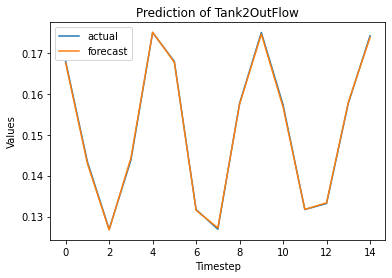

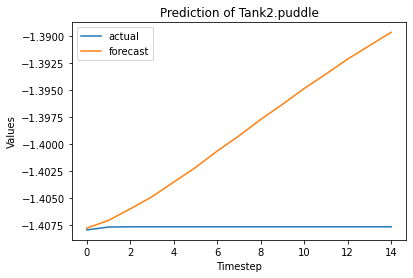

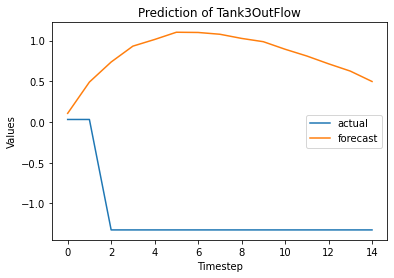

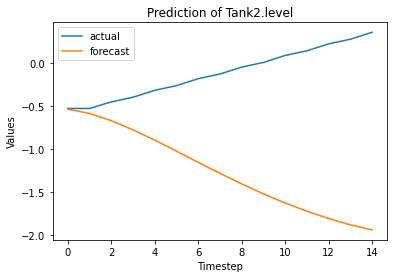

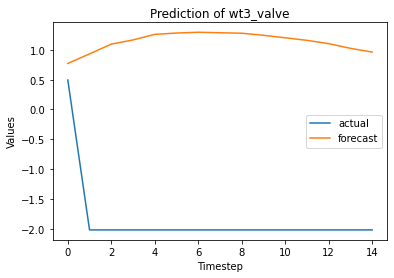

In [559]:
steps = 15
pred_valueFlip = valueFlip_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
pred_valueFlip_df = pd.DataFrame(pred_valueFlip, columns=input1.columns)

# plot_series(predictions_df, attr)
expected_valueFlip = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected_valueFlip, pred_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [560]:
expected_valueFlip = expected_valueFlip.reset_index(drop=True)
RMSE_vf = []
for feat in attr:
    RMSE_vf.append(root_mse(pred_valueFlip_df[feat], expected_valueFlip[feat]))
print(RMSE_vf)
write_result(RMSE_vf, result_file)

[0.0003174482724195006, 0.01034691593714035, 2.0695869064188663, 1.3699636366939856, 3.080757300874276]


### Stuck at zero

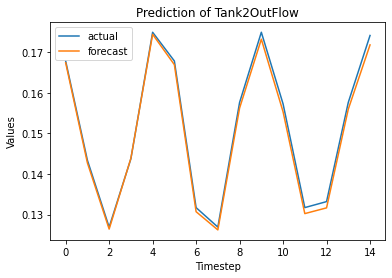

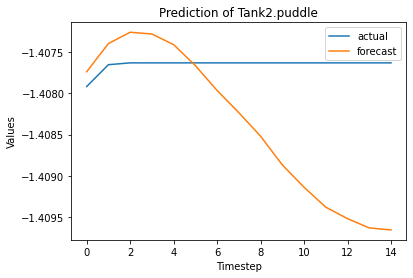

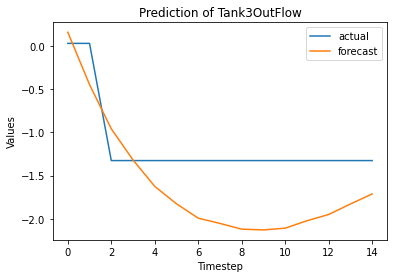

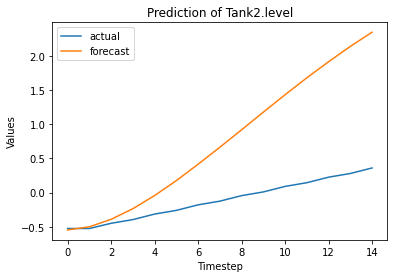

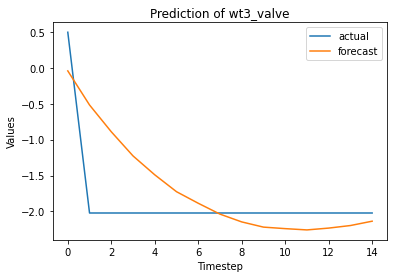

In [561]:
steps = 15
pred_stuckat0 = stuckat0_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
pred_stuckat0_df = pd.DataFrame(pred_stuckat0, columns=input1.columns)

# plot_series(predictions_df, attr)
expected_stuckat0 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected_stuckat0, pred_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [562]:
expected_stuckat0 = expected_stuckat0.reset_index(drop=True)
RMSE_s0 = []
for feat in attr:
    RMSE_s0.append(root_mse(pred_stuckat0_df[feat], expected_stuckat0[feat]))

# tested = root_mse(df['Tank1WaterLevel'].iloc[:steps], df_forecast['Tank1WaterLevel'])
# tested
print(RMSE_s0)
write_result(RMSE_s0, result_file)

[0.0012877183280209262, 0.0011618568984142798, 0.5689160548856163, 1.096713223364977, 0.582652674669131]


### stuckat one

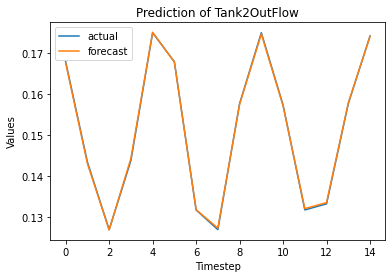

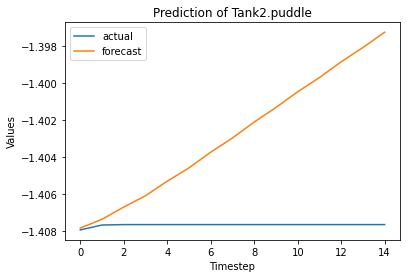

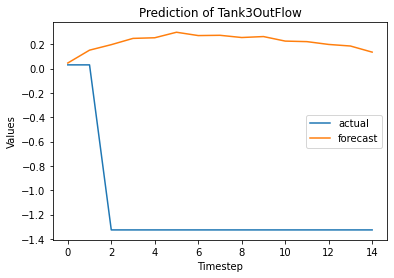

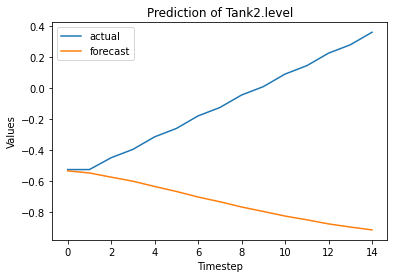

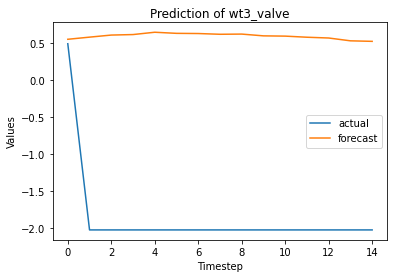

In [563]:
steps = 15
pred_stuckat1 = stuckat1_model.forecast(input1.values, steps=steps)

# Convert predictions to a DataFrame
pred_stuckat1_df = pd.DataFrame(pred_stuckat1, columns=input1.columns)
pred_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected_stuckat1 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected_stuckat1, pred_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [564]:
# pred_stuckat1_df["Tank1WaterLevel"]
pred_stuckat1_df

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0,0.167597,-1.407817,0.045872,-0.535365,0.555220
1,0.143034,-1.407344,0.151525,-0.548891,0.584189
2,0.126831,-1.406683,0.196649,-0.575873,0.612191
3,0.144283,-1.406073,0.248172,-0.602221,0.619067
4,0.175087,-1.405286,0.253356,-0.636119,0.650338
5,0.167811,-1.404569,0.298729,-0.668334,0.635494
6,0.131763,-1.403721,0.271369,-0.704407,0.633008
7,0.127274,-1.402953,0.273651,-0.734807,0.622829
8,0.157491,-1.402094,0.255361,-0.768831,0.625442


In [565]:
expected_stuckat1 = expected_stuckat1.reset_index(drop=True)
RMSE_s1 = []
for feat in attr:
    RMSE_s1.append(root_mse(pred_stuckat1_df[feat], expected_stuckat1[feat]))

print(RMSE_s1)
write_result(RMSE_s1, result_file)

[0.00026072993556382657, 0.005870384480235045, 1.4520725927932603, 0.7402500436845839, 2.5322625343038485]


### Predict with the pretrained models (Stuckat0 faults data)
#### Golden model

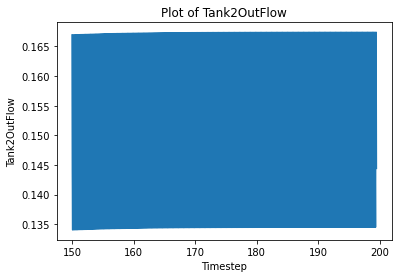

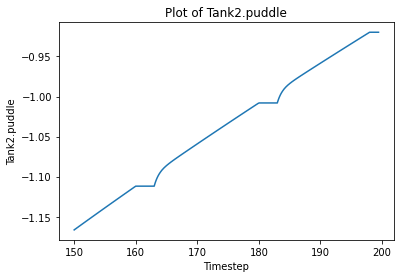

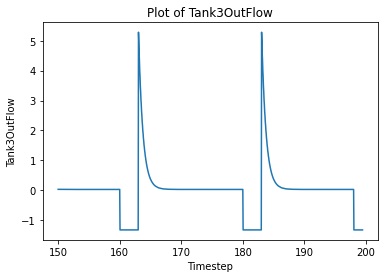

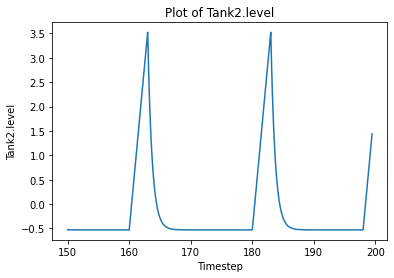

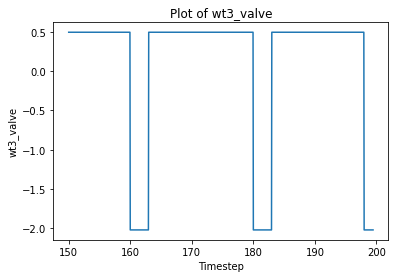

In [566]:
## SPecify the signal range
begin2 = 3000
finish2 = 3990
input2 = testData.iloc[begin2:finish2,:]

## Visualise the input signals
plot_series(input2,attr)

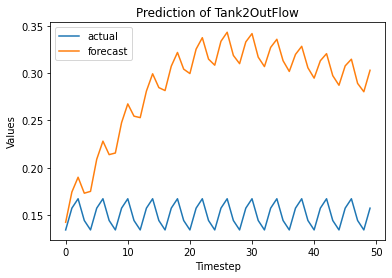

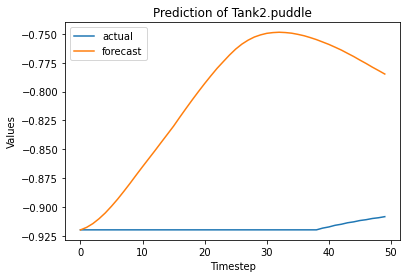

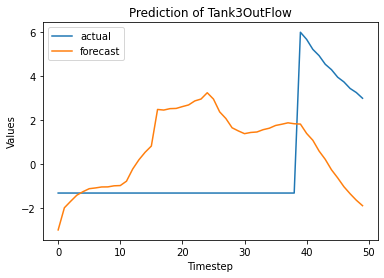

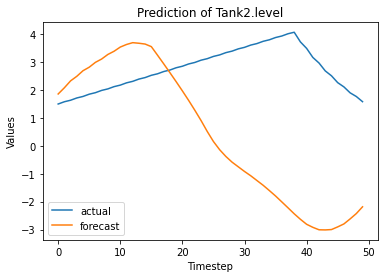

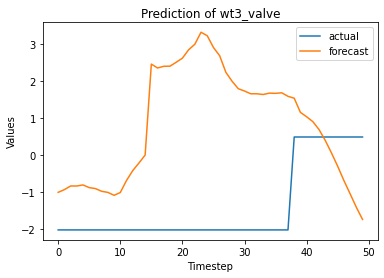

In [567]:
steps = 50
predictions2 = golden_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
predictions2_df = pd.DataFrame(predictions2, columns=input2.columns)

# plot_series(predictions_df, attr)
expected2 = testData.iloc[finish2:finish2+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2, predictions2_df, attr)
# plot_multiple_series(actual, pred, attr)

In [568]:
expected2 = expected2.reset_index(drop=True)
RMSE2_golden = []
for feat in attr:
    RMSE2_golden.append(root_mse(predictions2_df[feat], expected2[feat]))
print(RMSE2_golden)
write_result(RMSE2_golden, result_file)

[0.1426956082584463, 0.12657726730231905, 3.2444803442383696, 3.7209426587514076, 3.0690111611163124]


#### ValueFlip

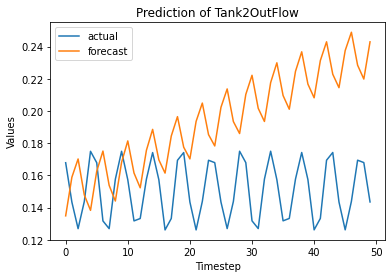

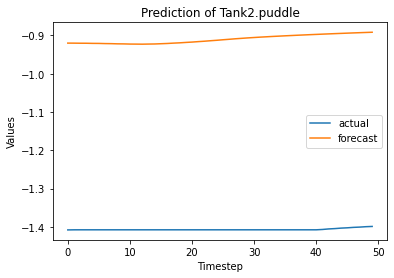

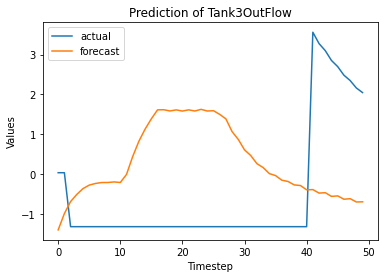

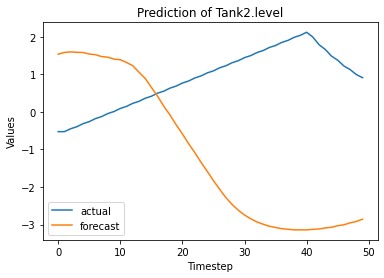

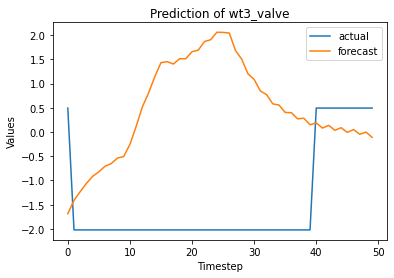

In [569]:
steps = 50
pred2_valueFlip = valueFlip_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
pred2_valueFlip_df = pd.DataFrame(pred2_valueFlip, columns=input2.columns)

# plot_series(predictions_df, attr)
expected2_valueFlip = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2_valueFlip, pred2_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [570]:
expected2_valueFlip = expected2_valueFlip.reset_index(drop=True)
RMSE2_vf = []
for feat in attr:
    RMSE2_vf.append(root_mse(pred2_valueFlip_df[feat], expected2_valueFlip[feat]))
print(RMSE2_vf)
write_result(RMSE2_vf, result_file)

[0.05526643689290657, 0.4967332767545592, 2.3078795967927648, 3.3277177048158384, 2.5404722836926603]


### Stuck at zero

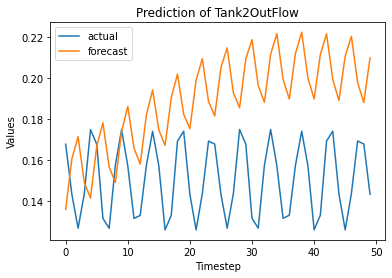

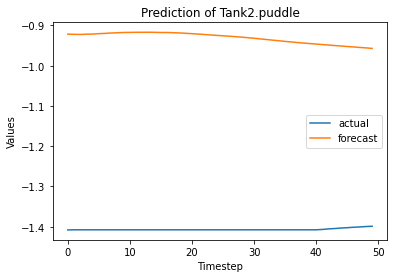

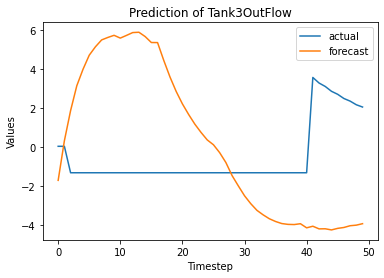

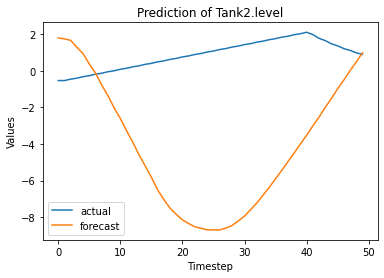

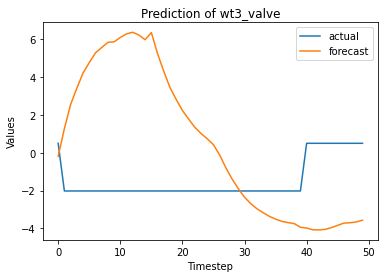

In [571]:
steps = 50
pred2_stuckat0 = stuckat0_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
pred2_stuckat0_df = pd.DataFrame(pred2_stuckat0, columns=input2.columns)

# plot_series(predictions_df, attr)
expected2_stuckat0 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2_stuckat0, pred2_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [572]:
expected2_stuckat0 = expected2_stuckat0.reset_index(drop=True)
RMSE2_s0 = []
for feat in attr:
    RMSE2_s0.append(root_mse(pred2_stuckat0_df[feat], expected2_stuckat0[feat]))

print(RMSE2_s0)
write_result(RMSE2_s0, result_file)

[0.04747166843553608, 0.4762130489652959, 4.93882330114442, 6.396679962291699, 4.9224115890404105]


### stuckat one

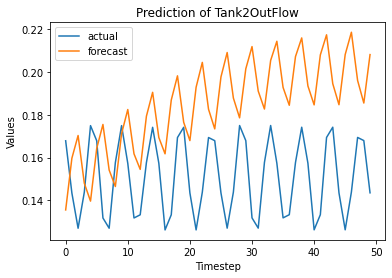

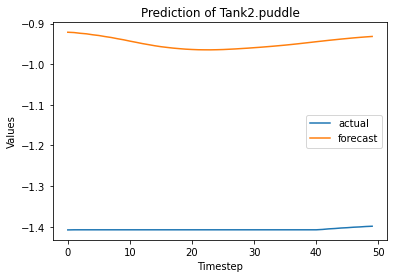

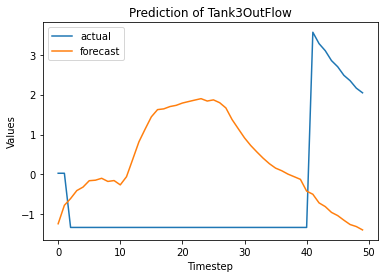

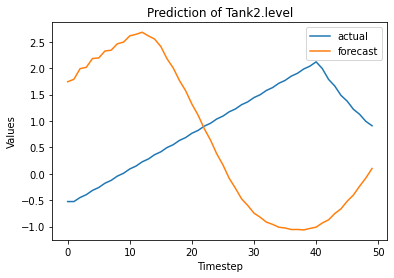

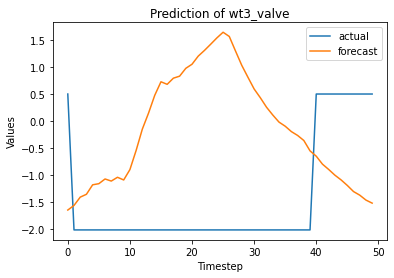

In [573]:
steps = 50
pred2_stuckat1 = stuckat1_model.forecast(input2.values, steps=steps)

# Convert predictions to a DataFrame
pred2_stuckat1_df = pd.DataFrame(pred2_stuckat1, columns=input2.columns)
pred2_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected2_stuckat1 = testData.iloc[finish:finish+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected2_stuckat1, pred2_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [574]:
expected2_stuckat1 = expected2_stuckat1.reset_index(drop=True)
RMSE2_s1 = []
for feat in attr:
    RMSE2_s1.append(root_mse(pred2_stuckat1_df[feat], expected2_stuckat1[feat]))

print(RMSE2_s1)
write_result(RMSE2_s1, result_file)

[0.04363394374337367, 0.45929501645911575, 2.522912239159543, 2.152780376167699, 2.22032598300347]


### Predict with the pretrained models (Stuckat1 fault data)
#### Golden model

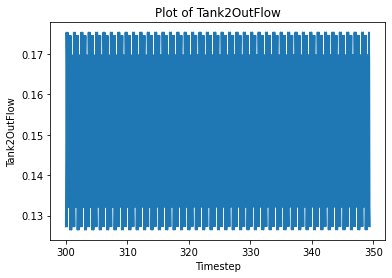

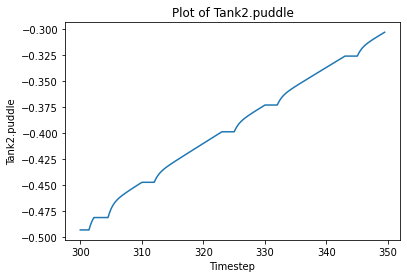

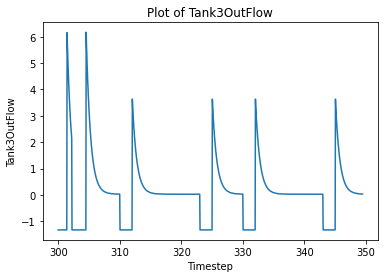

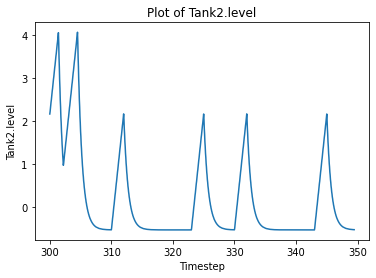

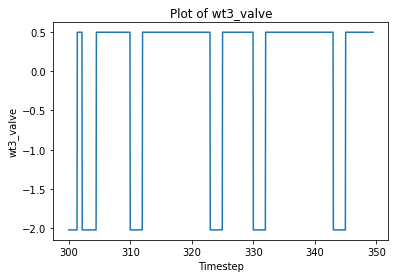

In [575]:
## SPecify the signal range
begin3 = 6000
finish3 = 6990
input3 = testData.iloc[begin3:finish3,:]

## Visualise the input signals
plot_series(input3,attr)

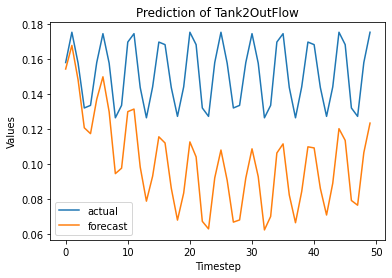

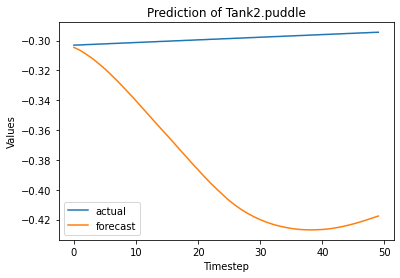

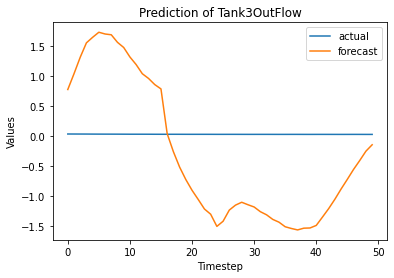

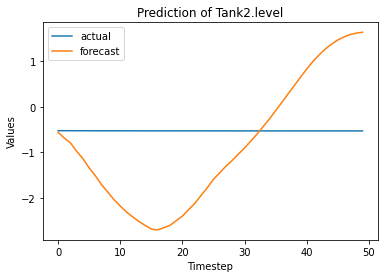

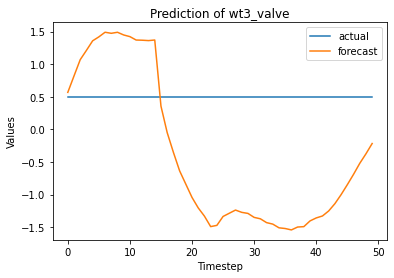

In [576]:
steps = 50
predictions3 = golden_model.forecast(input3.values, steps=steps)

# Convert predictions to a DataFrame
predictions3_df = pd.DataFrame(predictions3, columns=input3.columns)

# plot_series(predictions_df, attr)
expected3 = testData.iloc[finish3:finish3+steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected3, predictions3_df, attr)
# plot_multiple_series(actual, pred, attr)

In [577]:
expected3 = expected3.reset_index(drop=True)
RMSE3_golden = []
for feat in attr:
    RMSE3_golden.append(root_mse(predictions3_df[feat], expected3[feat]))
print(RMSE3_golden)
write_result(RMSE3_golden, result_file)

[0.05350181519919008, 0.09806276230780997, 1.212953918901406, 1.4311378793573069, 1.448818349535805]


#### ValueFlip

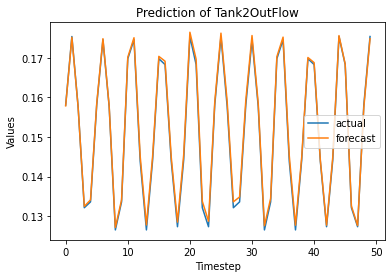

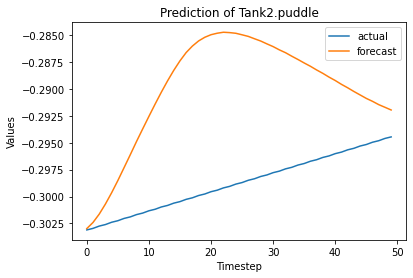

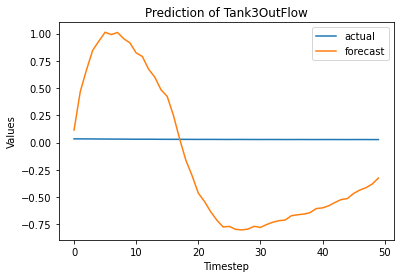

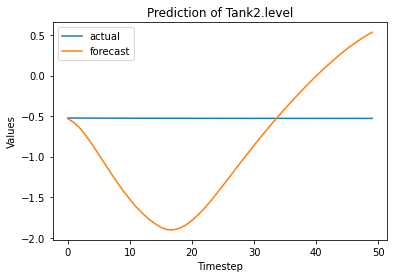

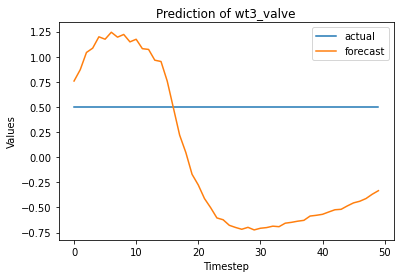

In [578]:
steps = 50
pred3_valueFlip = valueFlip_model.forecast(input3.values, steps=steps)

# Convert predictions to a DataFrame
pred3_valueFlip_df = pd.DataFrame(pred3_valueFlip, columns=input3.columns)

# plot_series(predictions_df, attr)
expected3_valueFlip = testData.iloc[finish3:finish3 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected3_valueFlip, pred3_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [579]:
expected3_valueFlip = expected3_valueFlip.reset_index(drop=True)
RMSE3_vf = []
for feat in attr:
    RMSE3_vf.append(root_mse(pred3_valueFlip_df[feat], expected3_valueFlip[feat]))
print(RMSE3_vf)
write_result(RMSE3_vf, result_file)

[0.000855709141301786, 0.009773081638131174, 0.6693659437119512, 0.8292011815195152, 0.9015678944411902]


### Stuck at zero

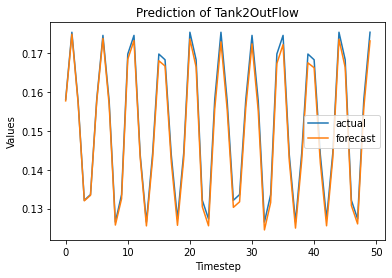

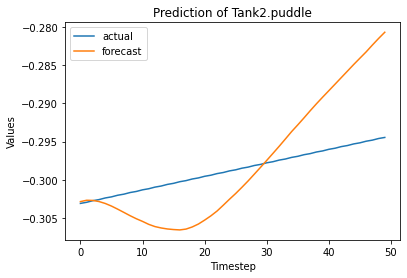

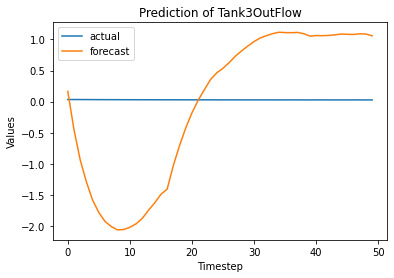

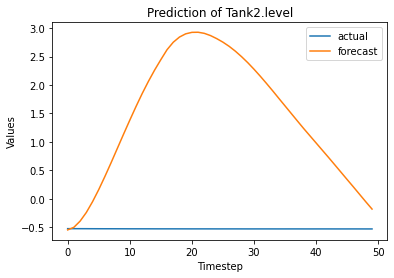

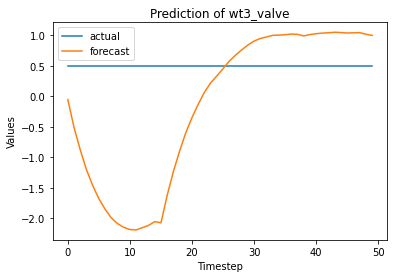

In [580]:
steps = 50
pred3_stuckat0 = stuckat0_model.forecast(input3.values, steps=steps)

# Convert predictions to a DataFrame
pred3_stuckat0_df = pd.DataFrame(pred3_stuckat0, columns=input3.columns)

# plot_series(predictions_df, attr)
expected3_stuckat0 = testData.iloc[finish3:finish3 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected3_stuckat0, pred3_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [581]:
expected3_stuckat0 = expected3_stuckat0.reset_index(drop=True)
RMSE3_s0 = []
for feat in attr:
    RMSE3_s0.append(root_mse(pred3_stuckat0_df[feat], expected3_stuckat0[feat]))

print(RMSE3_s0)
write_result(RMSE3_s0, result_file)

[0.0016847339075068647, 0.006117054150569977, 1.2199045054572968, 2.266108757298263, 1.4074784845506692]


### stuckat one

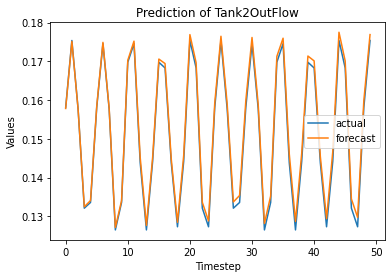

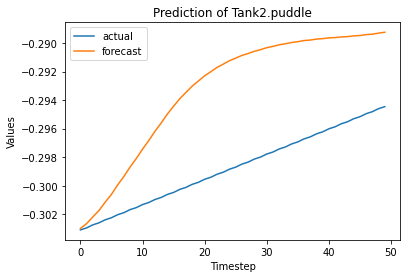

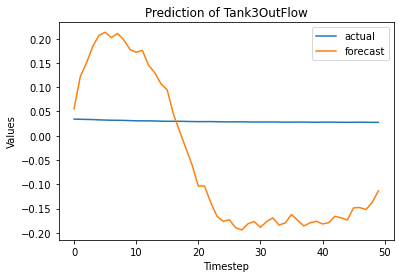

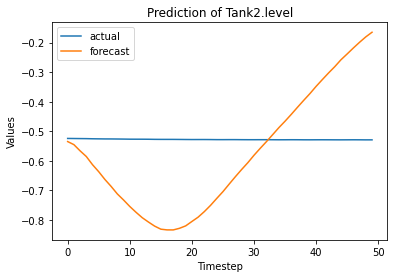

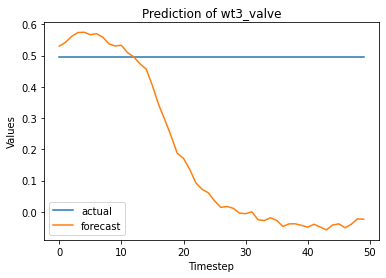

In [582]:
steps = 50
pred3_stuckat1 = stuckat1_model.forecast(input3.values, steps=steps)

# Convert predictions to a DataFrame
pred3_stuckat1_df = pd.DataFrame(pred3_stuckat1, columns=input3.columns)
pred3_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected3_stuckat1 = testData.iloc[finish3:finish3 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected3_stuckat1, pred3_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [583]:
expected3_stuckat1 = expected3_stuckat1.reset_index(drop=True)
RMSE3_s1 = []
for feat in attr:
    RMSE3_s1.append(root_mse(pred3_stuckat1_df[feat], expected3_stuckat1[feat]))

print(RMSE3_s1)
write_result(RMSE3_s1, result_file)

[0.0014586197735812982, 0.005949129271937777, 0.1696099535070992, 0.2101221972512495, 0.39485891537719825]


### Predict with the pretrained models (ValueFlip fault data)
#### Golden model

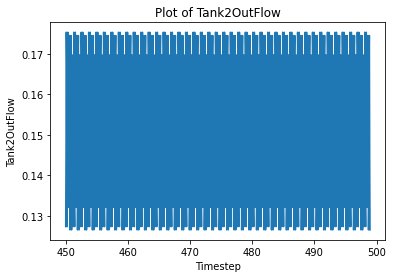

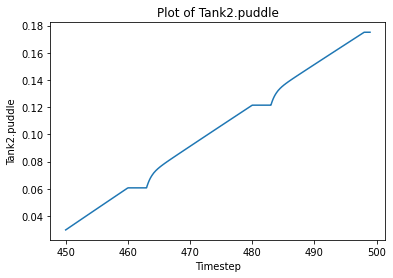

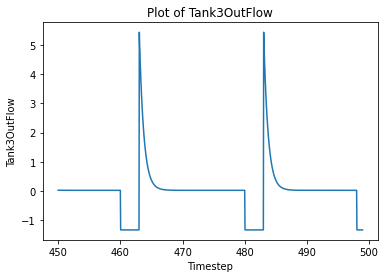

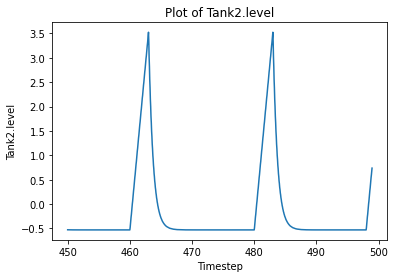

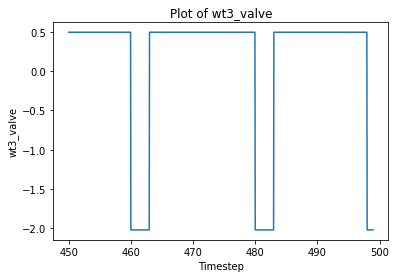

In [584]:
## SPecify the signal range
begin4 = 9000
finish4 = 9980
input4 = testData.iloc[begin4:finish4,:]

## Visualise the input signals
plot_series(input4,attr)

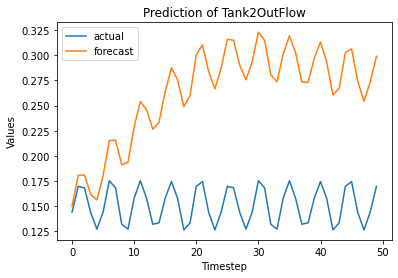

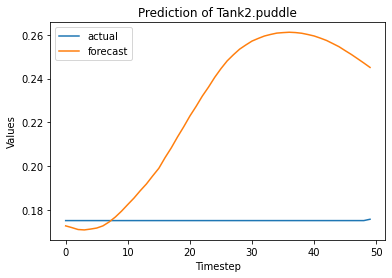

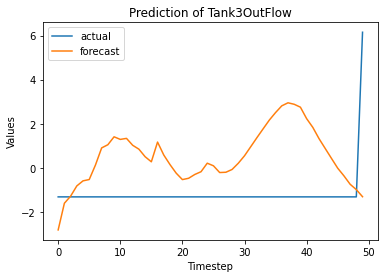

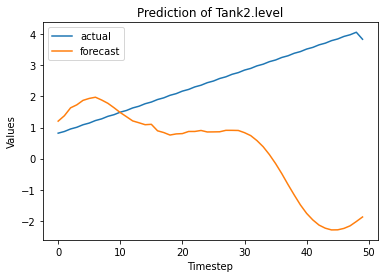

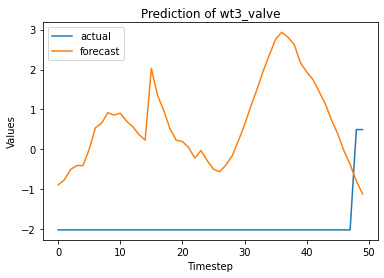

In [585]:
steps = 50
predictions4 = golden_model.forecast(input4.values, steps=steps)

# Convert predictions to a DataFrame
predictions4_df = pd.DataFrame(predictions4, columns=input4.columns)

# plot_series(predictions_df, attr)
expected4 = testData.iloc[finish4:finish4 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected4, predictions4_df, attr)
# plot_multiple_series(actual, pred, attr)

In [586]:
expected4 = expected4.reset_index(drop=True)
RMSE4_golden = []
for feat in attr:
    RMSE4_golden.append(root_mse(predictions4_df[feat], expected4[feat]))
print(RMSE4_golden)
write_result(RMSE4_golden, result_file)

[0.1189267780057737, 0.060816720717539935, 2.447924021041161, 3.168205277595452, 2.8706053528686764]


#### ValueFlip

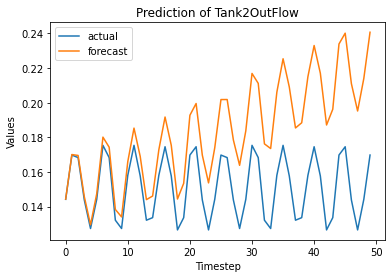

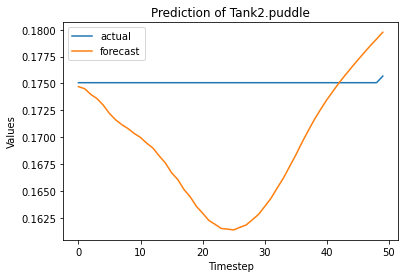

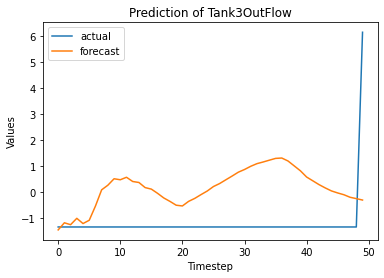

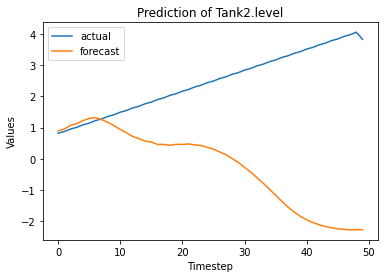

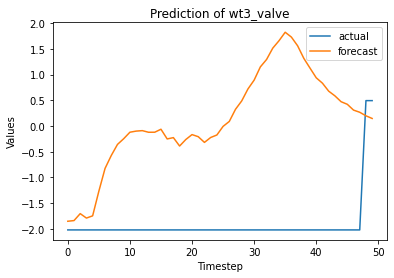

In [587]:
steps = 50
pred4_valueFlip = valueFlip_model.forecast(input4.values, steps=steps)

# Convert predictions to a DataFrame
pred4_valueFlip_df = pd.DataFrame(pred4_valueFlip, columns=input4.columns)

# plot_series(predictions_df, attr)
expected4_valueFlip = testData.iloc[finish4:finish4 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected4_valueFlip, pred4_valueFlip_df, attr)
# plot_multiple_series(actual, pred, attr)

In [588]:
expected4_valueFlip = expected4_valueFlip.reset_index(drop=True)
RMSE4_vf = []
for feat in attr:
    RMSE4_vf.append(root_mse(pred4_valueFlip_df[feat], expected4_valueFlip[feat]))
print(RMSE4_vf)
write_result(RMSE4_vf, result_file)

[0.03956939622037849, 0.007933591606535362, 1.8670877424990588, 3.484505544122966, 2.2850730149591985]


### Stuck at zero

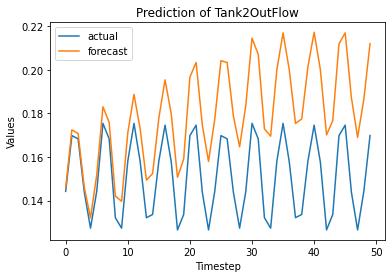

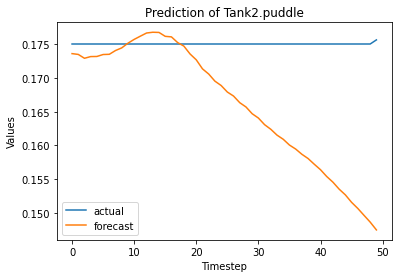

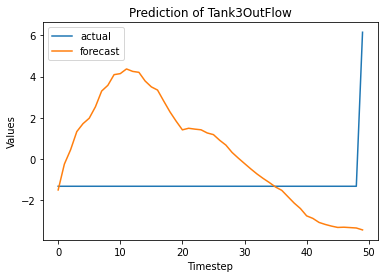

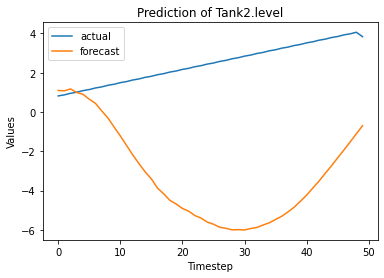

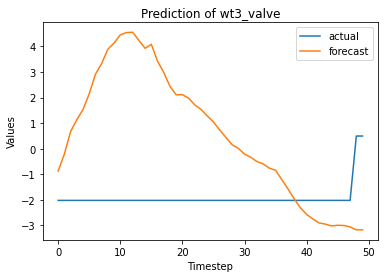

In [589]:
steps = 50
pred4_stuckat0 = stuckat0_model.forecast(input4.values, steps=steps)

# Convert predictions to a DataFrame
pred4_stuckat0_df = pd.DataFrame(pred4_stuckat0, columns=input4.columns)

# plot_series(predictions_df, attr)
expected4_stuckat0 = testData.iloc[finish4:finish4 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected4_stuckat0, pred4_stuckat0_df, attr)
# plot_multiple_series(actual, pred, attr)

In [590]:
expected4_stuckat0 = expected4_stuckat0.reset_index(drop=True)
RMSE4_s0 = []
for feat in attr:
    RMSE4_s0.append(root_mse(pred4_stuckat0_df[feat], expected4_stuckat0[feat]))

print(RMSE4_s0)
write_result(RMSE4_s0, result_file)

[0.03191171129871941, 0.012727710617721953, 3.2907699745713046, 6.4308297434428585, 3.6301944616774646]


### stuckat one

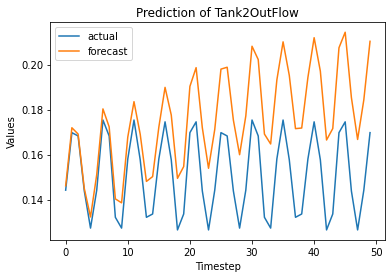

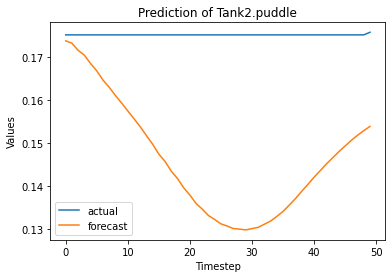

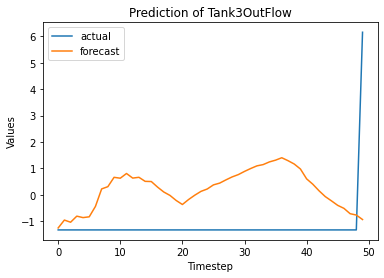

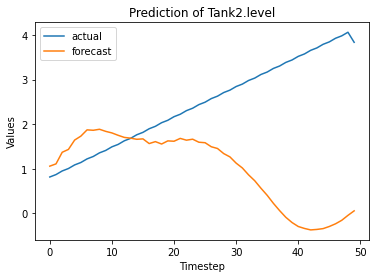

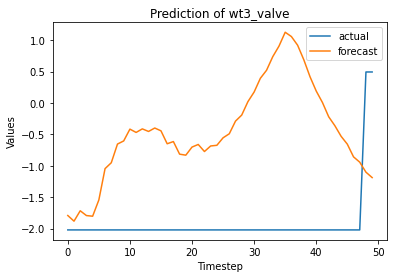

In [591]:
steps = 50
pred4_stuckat1 = stuckat1_model.forecast(input4.values, steps=steps)

# Convert predictions to a DataFrame
pred4_stuckat1_df = pd.DataFrame(pred4_stuckat1, columns=input4.columns)
pred4_stuckat1_df.index.name = "time"

# plot_series(predictions_df, attr)
expected4_stuckat1 = testData.iloc[finish4:finish4 + steps,:]
# plot_multiple_series(test.iloc[:15,:], predictions_df, attr)
plot_multiple_series(expected4_stuckat1, pred4_stuckat1_df, attr)
# plot_multiple_series(actual, pred, attr)

In [592]:
expected4_stuckat1 = expected4_stuckat1.reset_index(drop=True)
RMSE4_s1 = []
for feat in attr:
    RMSE4_s1.append(root_mse(pred4_stuckat1_df[feat], expected4_stuckat1[feat]))

print(RMSE4_s1)
write_result(RMSE4_s1, result_file)

[0.028244028332323316, 0.03174183621020074, 1.9684733420237899, 2.238873930860063, 1.7538208764029406]


### End of the Notebook